## Comparing Logit Regression with CART for Classification: Loan Decisions 

#### Introduction: Packages and Data

In [2]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import logit
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [3]:
#import data
df= pd.read_csv("loans.csv")

In [4]:
#inspect data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516 entries, 0 to 9515
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   default      9516 non-null   int64  
 1   installment  9516 non-null   int64  
 2   log_income   9516 non-null   float64
 3   fico_score   9516 non-null   int64  
 4   rev_balance  9516 non-null   float64
 5   inquiries    9516 non-null   int64  
 6   records      9516 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 520.5 KB


In [5]:
df.head()

,default,installment,log_income,fico_score,rev_balance,inquiries,records
0,0,829,4.93,737,28.85,0,0
1,0,228,4.81,707,33.62,0,0
2,0,367,4.51,682,3.51,1,0
3,0,162,4.93,712,33.67,1,0
4,0,103,4.91,667,4.74,0,0


In [7]:
df.default.value_counts(normalize = True)

default
0    0.840164
1    0.159836
Name: proportion, dtype: float64

In [8]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 42)

In [15]:
x = df_train.copy()
y = x.pop('default')
x_test = df_test.copy()
y_test = x_test.pop('default')

#### Helper Functions

We need these functions to calculate profit for each scennario based on different models. 

In [23]:
def profit(y, y_pred, cutoff = 0.5, verbose = False): 
    '''
    Calculates the profit for each observation (applicant) given actual y values, predicted probabilities, and a probability cutoff. 
    '''
    will_default = np.where(y_pred >= cutoff, 1,0)
    cm = confusion_matrix(y, will_default)
    if verbose:
        ConfusionMatrixDisplay.from_predictions(
            y,
            will_default,
            display_labels = ["No Default", "Default"]
        )
    cm_profit = 1000*cm[0,0]-5000*cm[1,0]
    return cm_profit/len(y)

def profit_table(y, y_pred, cutoffs = np.arange(0,1.01,0.1)):
    '''
    Calculates the profit for each applicant for each cutoff given predicted probabilities, 
    actual y values, and a set of cutoffs. It returs a two-column data frame once column for cutoff values
    and one for profit for them.
    '''
    return pd.DataFrame({'cutoff': cutoffs, 
                        'profit': [profit(y, y_pred, cutoff) for cutoff in cutoffs]})

def best_profit_and_cutoff(y, y_pred):
    '''
    Gives optimal cutoff and optimal profit given predicted probabilities and actual y values.
    '''
    pf = profit_table(y, y_pred)
    idx = pf.profit.idxmax()
    return pf.loc[idx]


#### Logit Regression Analysis

In [24]:
#build and fit the model
formula = "default~ installment + log_income + fico_score + rev_balance + inquiries + records"
est = logit(formula = formula, data= df_train).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.415078
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 6661
Model:                          Logit   Df Residuals:                     6654
Method:                           MLE   Df Model:                            6
Date:                Thu, 27 Mar 2025   Pseudo R-squ.:                 0.05338
Time:                        12:08:32   Log-Likelihood:                -2764.8
converged:                       True   LL-Null:                       -2920.7
Covariance Type:            nonrobust   LLR p-value:                 2.415e-64
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       9.7634      0.994      9.824      0.000       7.816      11.711
installment     0.0013    

### Classification Tree Model

In [25]:
def viz_tree(tree, font = 12, figsize = (16,10)):
    '''
    we will use this function to draw the classification tree
    '''
    plt.figure(figsize=figsize)
    _= plot_tree(tree,
                feature_names =x.columns,
                filled = True,
                fontsize = font)

In [26]:
#build the model
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(x,y)

DecisionTreeClassifier(random_state=42)

In [28]:
#calculate profit based on this tree
y_pred = tree.predict_proba(x_test)[:,1]
profit_table(y_test, y_pred)

,cutoff,profit
0,0.0,0.000000
1,0.1,74.255692
2,0.2,74.255692
3,0.3,74.255692
4,0.4,74.255692
5,0.5,74.255692
6,0.6,74.255692
7,0.7,74.255692
8,0.8,74.255692
9,0.9,74.255692


In [29]:
#lets see how this profit table compares to the profit table from the logistic regression model above
y_pred = est.predict(x_test)
profit_table(y_test, y_pred)

,cutoff,profit
0,0.0,0.000000
1,0.1,152.014011
2,0.2,153.415061
3,0.3,113.835377
4,0.4,57.793345
5,0.5,42.732049
6,0.6,32.574431
7,0.7,32.924694
8,0.8,32.924694
9,0.9,33.274956


It appears the logit model performs much better then the classification tree. This is because we used the default parameters in the tree model. This can lead to overfitting (see below how big this tree is). Lets try to set our hyperparameters to improve the tree model. 

In [30]:
tree.tree_.max_depth, tree.tree_.node_count

(35, 2515)

#### Cost Complexity Pruning

We will use ccp to find the best tree model to maximize profit. To find the tree with the best out of sample preformance (OOS) we (1) generate a list of ccp_alphas that corrisponde to different pruned trees; (2) build the pruned tree for each value and evaluate its in-sample and out-of-sample performance; (3) pick the pruned tree with the best OOS performance.

In [31]:
#build the model
tree = DecisionTreeClassifier(random_state = 42)

In [32]:
#create ccp_alphas path
path = tree.cost_complexity_pruning_path(x,y)
alphas = path.ccp_alphas

In [33]:
#build trees for each ccp_alpha using a loop
trees = []
for alpha in alphas:
    tree = DecisionTreeClassifier(random_state = 42, ccp_alpha = alpha)
    tree.fit(x,y)
    trees.append(tree)

In [37]:
# see how many trees were generated
print(f" This process generated {len(trees)} trees.")

 This process generated 436 trees.


Let's find the tree with the highest profit oos.

In [42]:
#function to find optimal profit and best cutoff point
def all_trees_profits_cutoffs(x,y):
    max_profit = []
    best_cutoff = []
    for tree in trees: 
        y_pred = tree.predict_proba(x)[:,1]
        pf = best_profit_and_cutoff(y, y_pred)
        max_profit.append(pf['profit'])
        best_cutoff.append(pf['cutoff'])
    return max_profit, best_cutoff

In [43]:
#use function above with our train data and test data
train_profits, train_cutoffs = all_trees_profits_cutoffs(x,y)
test_profits, test_cutoffs = all_trees_profits_cutoffs(x_test, y_test)

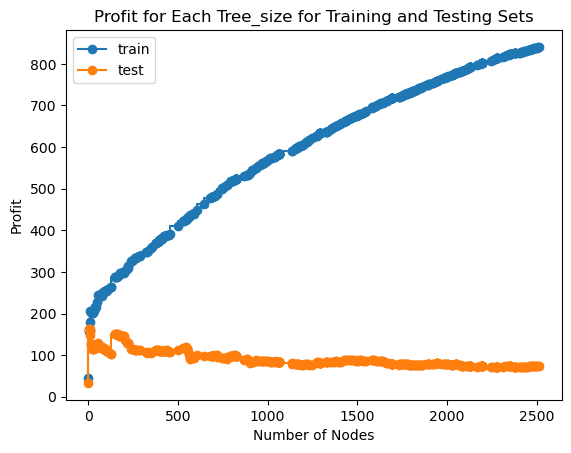

In [45]:
#visualize all tree
node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]

fig, ax = plt.subplots()
ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Profit")
ax.set_title("Profit for Each Tree_size for Training and Testing Sets")
ax.plot(node_counts, train_profits, marker = "o", label = "train", drawstyle = "steps-post")
ax.plot(node_counts, test_profits, marker = "o", label = "test", drawstyle = "steps-post")
ax.legend()
plt.show()

The figure above shows that quickly after 0 nodes or as the tree grows (around 20-50 based on eye) the train data is overfitting and the test is underfitting. So, let's zoom in before this trend starts

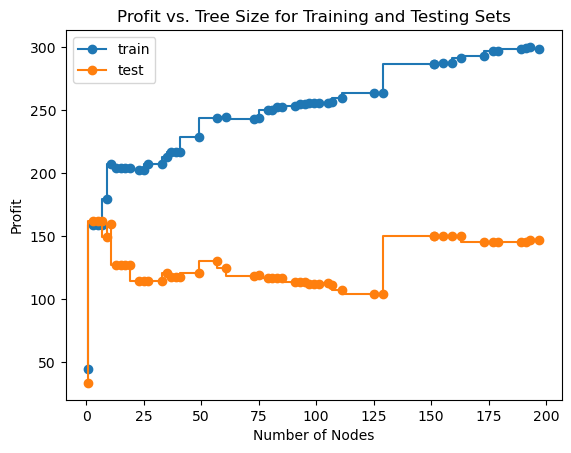

In [48]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Profit")
ax.set_title("Profit vs. Tree Size for Training and Testing Sets")
ax.plot(node_counts[-50:], train_profits[-50:], marker = "o", label = "train", drawstyle = "steps-post")
ax.plot(node_counts[-50:], test_profits[-50:], marker = "o", label = "test", drawstyle = "steps-post")
ax.legend()
plt.show()


In [49]:
#Let's identify the tree witht he heighest profit
opt_idx = np.argmax(test_profits)
print(f"Profit of max-profit tree = ${max(test_profits):.2f}")
print(f"Size of max-profit tree = {node_counts[opt_idx]} nodes")
print(f"Optimal cutoff for chosen tree = {test_cutoffs[opt_idx]:.2f}")

Profit of max-profit tree = $161.82
Size of max-profit tree = 7 nodes
Optimal cutoff for chosen tree = 0.20


This tree performs much better than the logit regressio

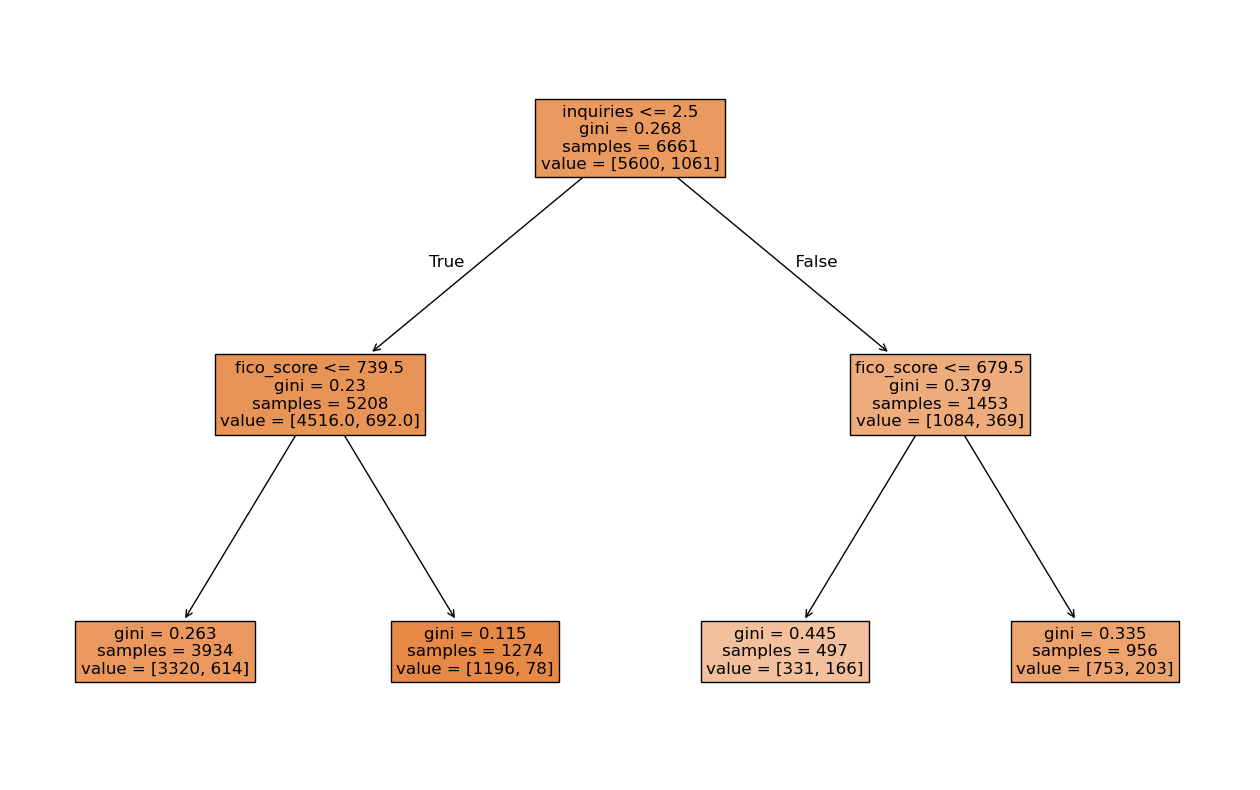

In [50]:
tree = trees[opt_idx]
viz_tree(tree)

## The End!!!